In [1]:
!pip install denoising_diffusion_pytorch
!pip install labml-nn

## Whole Trajectory Prediction

In [3]:

import glob
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import random

from copy import deepcopy
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
from typing import Tuple, Optional, List
from tqdm import tqdm

# Torch imports
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision

from PIL import Image
from torch import nn
from torchvision import transforms
from torchvision.datasets.folder import default_loader as loader 

# labml imports
from labml import lab, tracker, experiment, monit
from labml.configs import BaseConfigs, option
from labml_helpers.device import DeviceConfigs
from labml_nn.diffusion.ddpm import DenoiseDiffusion
from labml_nn.diffusion.ddpm.unet import UNet
# from labml_nn.diffusion.ddpm.experiment import Configs
from labml_nn.diffusion.ddpm.utils import gather

In [4]:
IMAGE_SIZE = 32

In [5]:
class RandomTrajectory:
    def __init__(self, img_size, step_size, step_number, use_given_probs=False, given_probs=None):
        self.img_size = img_size
        self.step_size = step_size
        self.step_number = step_number
        self.use_given_probs = use_given_probs
        self.given_probs = given_probs
        if use_given_probs:
            assert self.given_probs.shape == (IMAGE_SIZE, IMAGE_SIZE, 9)
            print('Shape assertion true!')
        self.curr_id = [0,0] # Indicates the index of the current point to add trajectory
        if use_given_probs:
            # Find the first index that doesn't have all zeros as the probabilities
            for i in range(IMAGE_SIZE):
                for j in range(IMAGE_SIZE):
                    if not (given_probs[i,j,:] == 0).all():
                        self.curr_id = [i,j]
                        break
            print('self.curr_id: {}'.format(self.curr_id))
            self.dir_probs = given_probs[self.curr_id[0], self.curr_id[1]]
            print('self.dir_probs after curr_id: {}'.format(self.dir_probs))
        else:
            self.dir_probs = np.array([ # There are 9 possible directions, these are the probabilities of a direction
                [0.01, 0.05,0.11],
                [0.05, 0.01, 0.22], # Going right bottom has the highest probability
                [0.11, 0.22 ,0.22]
            ]).flatten()
        
        self.dirs = np.array([ # Directions of the indices in self.dir_probs correspondingly
            [-1,-1], [-1,0], [-1,+1], 
            [0, -1], [0, 0], [0, +1],
            [+1,-1], [+1,0], [+1,+1]
        ])

        self.frame_num = 0
        
    def reached_end(self):
        return self.curr_id[0] >= self.img.shape[0] or self.curr_id[1] >= self.img.shape[1]
        
    def reset(self):
        self.img = np.zeros((self.img_size, self.img_size)) # 1s will indicate the trajectory - input of the diffusion model will be a 1 channel img anyways
        if self.use_given_probs:
            # Find the first index that doesn't have all zeros as the probabilities
            for i in range(IMAGE_SIZE):
                for j in range(IMAGE_SIZE):
                    if not (self.given_probs[i,j,:] == 0).all():
                        self.curr_id = [i,j]
                        break
        else:
            self.curr_id = [0,0]   
        
    def create_traj(self):
        self.reset()
        for _ in range(self.step_number):
            if self.use_given_probs:
                self.dir_probs = self.given_probs[self.curr_id[0], self.curr_id[1]]
            if self.reached_end():
                break
            self.img[self.curr_id[0], self.curr_id[1]] = 1
            self.add_step()
        # print("Trajectory planning finished")

        plt.imsave('diffusion_mock_dset/frame_{:05d}.jpg'.format(self.frame_num), self.img, cmap = plt.cm.gray)
        self.frame_num += 1
        # return deepcopy(self.img)
        
    def add_step(self):
        print('self.dir_probs: {}'.format(self.dir_probs))
        dir_id = np.random.choice(len(self.dir_probs), 1, p=self.dir_probs)[0]
        curr_dir = self.dirs[dir_id]
        while not self.is_dir_possible(curr_dir):
            dir_id = np.random.choice(len(self.dir_probs), 1, p=self.dir_probs)[0]
            curr_dir = self.dirs[dir_id] # All of the trajectories should be feasible
        self.curr_id += self.step_size * curr_dir
        
    def is_dir_possible(self, curr_dir):
        # Check the 1st axis
        is_pos = True
        for curr_ax in range(2):
            if self.curr_id[curr_ax] <= 0:
                if curr_dir[curr_ax] < 0:
                    is_pos = False
            elif self.curr_id[curr_ax] >= self.img_size-1:
                if curr_dir[curr_ax] > 0:
                    is_pos = False 
        return is_pos

    def plot(self, img=None, ax=None):
        plt.figure(figsize=(10,10))
        plt.imshow(self.img)


# rand_traj = RandomTrajectory(128, 1, 500)
# rand_traj.create_traj()
# rand_traj.plot()

In [61]:
# Create the dataset
# rand_traj = RandomTrajectory(IMAGE_SIZE, 1, IMAGE_SIZE*3)
# pbar = tqdm(total=10000)
# for _ in range(10000):
#     rand_traj.create_traj()
#     pbar.update(1)

rand_traj = RandomTrajectory(IMAGE_SIZE, 1, IMAGE_SIZE*3, use_given_probs=True, given_probs=img_prob_dist)
rand_traj.create_traj()
# pbar = tqdm(total=10000)
# for _ in range(10000):
#     rand_traj.create_traj()
#     pbar.update(1)

Shape assertion true!
self.curr_id: [24, 3]
self.dir_probs after curr_id: [0. 0. 1. 0. 0. 0. 0. 0. 0.]
self.dir_probs: [0. 0. 0. 0. 0. 0. 0. 0. 0.]


ValueError: probabilities do not sum to 1

In [6]:
class RandTrajDataset(data.Dataset):
    def __init__(self, img_size,
                 data_root='/home/irmak/Workspace/DAWGE/contrastive_learning/notebooks/diffusion_mock_dset'):
        # self.dataset_size = 10000
        self.data_root = data_root
        self.dataset_size = len(glob.glob(f'{data_root}/*'))
        print('self.dataset_size: {}'.format(self.dataset_size))
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.CenterCrop((img_size,img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5))
        ])

    def _get_image(self, path):
        img = self.transform(loader(path))
        return torch.FloatTensor(img)

    def __len__(self):
        return self.dataset_size # Let's give this a try first

    def __getitem__(self, index):
        path = '{}/frame_{:05d}.jpg'.format(self.data_root, index)
        # img = torch.FloatTensor([self.rand_trajs[index]])
        return self._get_image(path)

    # Method to plot random trajectories created
    def show(self, num_imgs=12):
        nrows = 3
        ncols = math.ceil(num_imgs / nrows)
        fig, axs = plt.subplots(figsize=(ncols*10,nrows*10), nrows=nrows, ncols=ncols)
        for i in range(num_imgs):
            axs_row = int(i / nrows)
            axs_col = int(i % nrows)

            rand_index = random.randint(0,self.dataset_size-1)
            img = self.__getitem__(rand_index).detach().numpy()

            axs[axs_col, axs_row].imshow(img[0])        



In [6]:
dataset = RandTrajDataset(IMAGE_SIZE, data_root='/home/irmak/Workspace/DAWGE/contrastive_learning/notebooks/diffusion_dset')
dataloader = data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)
batch = next(iter(dataloader))
print('batch.shape: {}'.format(batch.shape))

self.dataset_size: 102
batch.shape: torch.Size([8, 1, 32, 32])


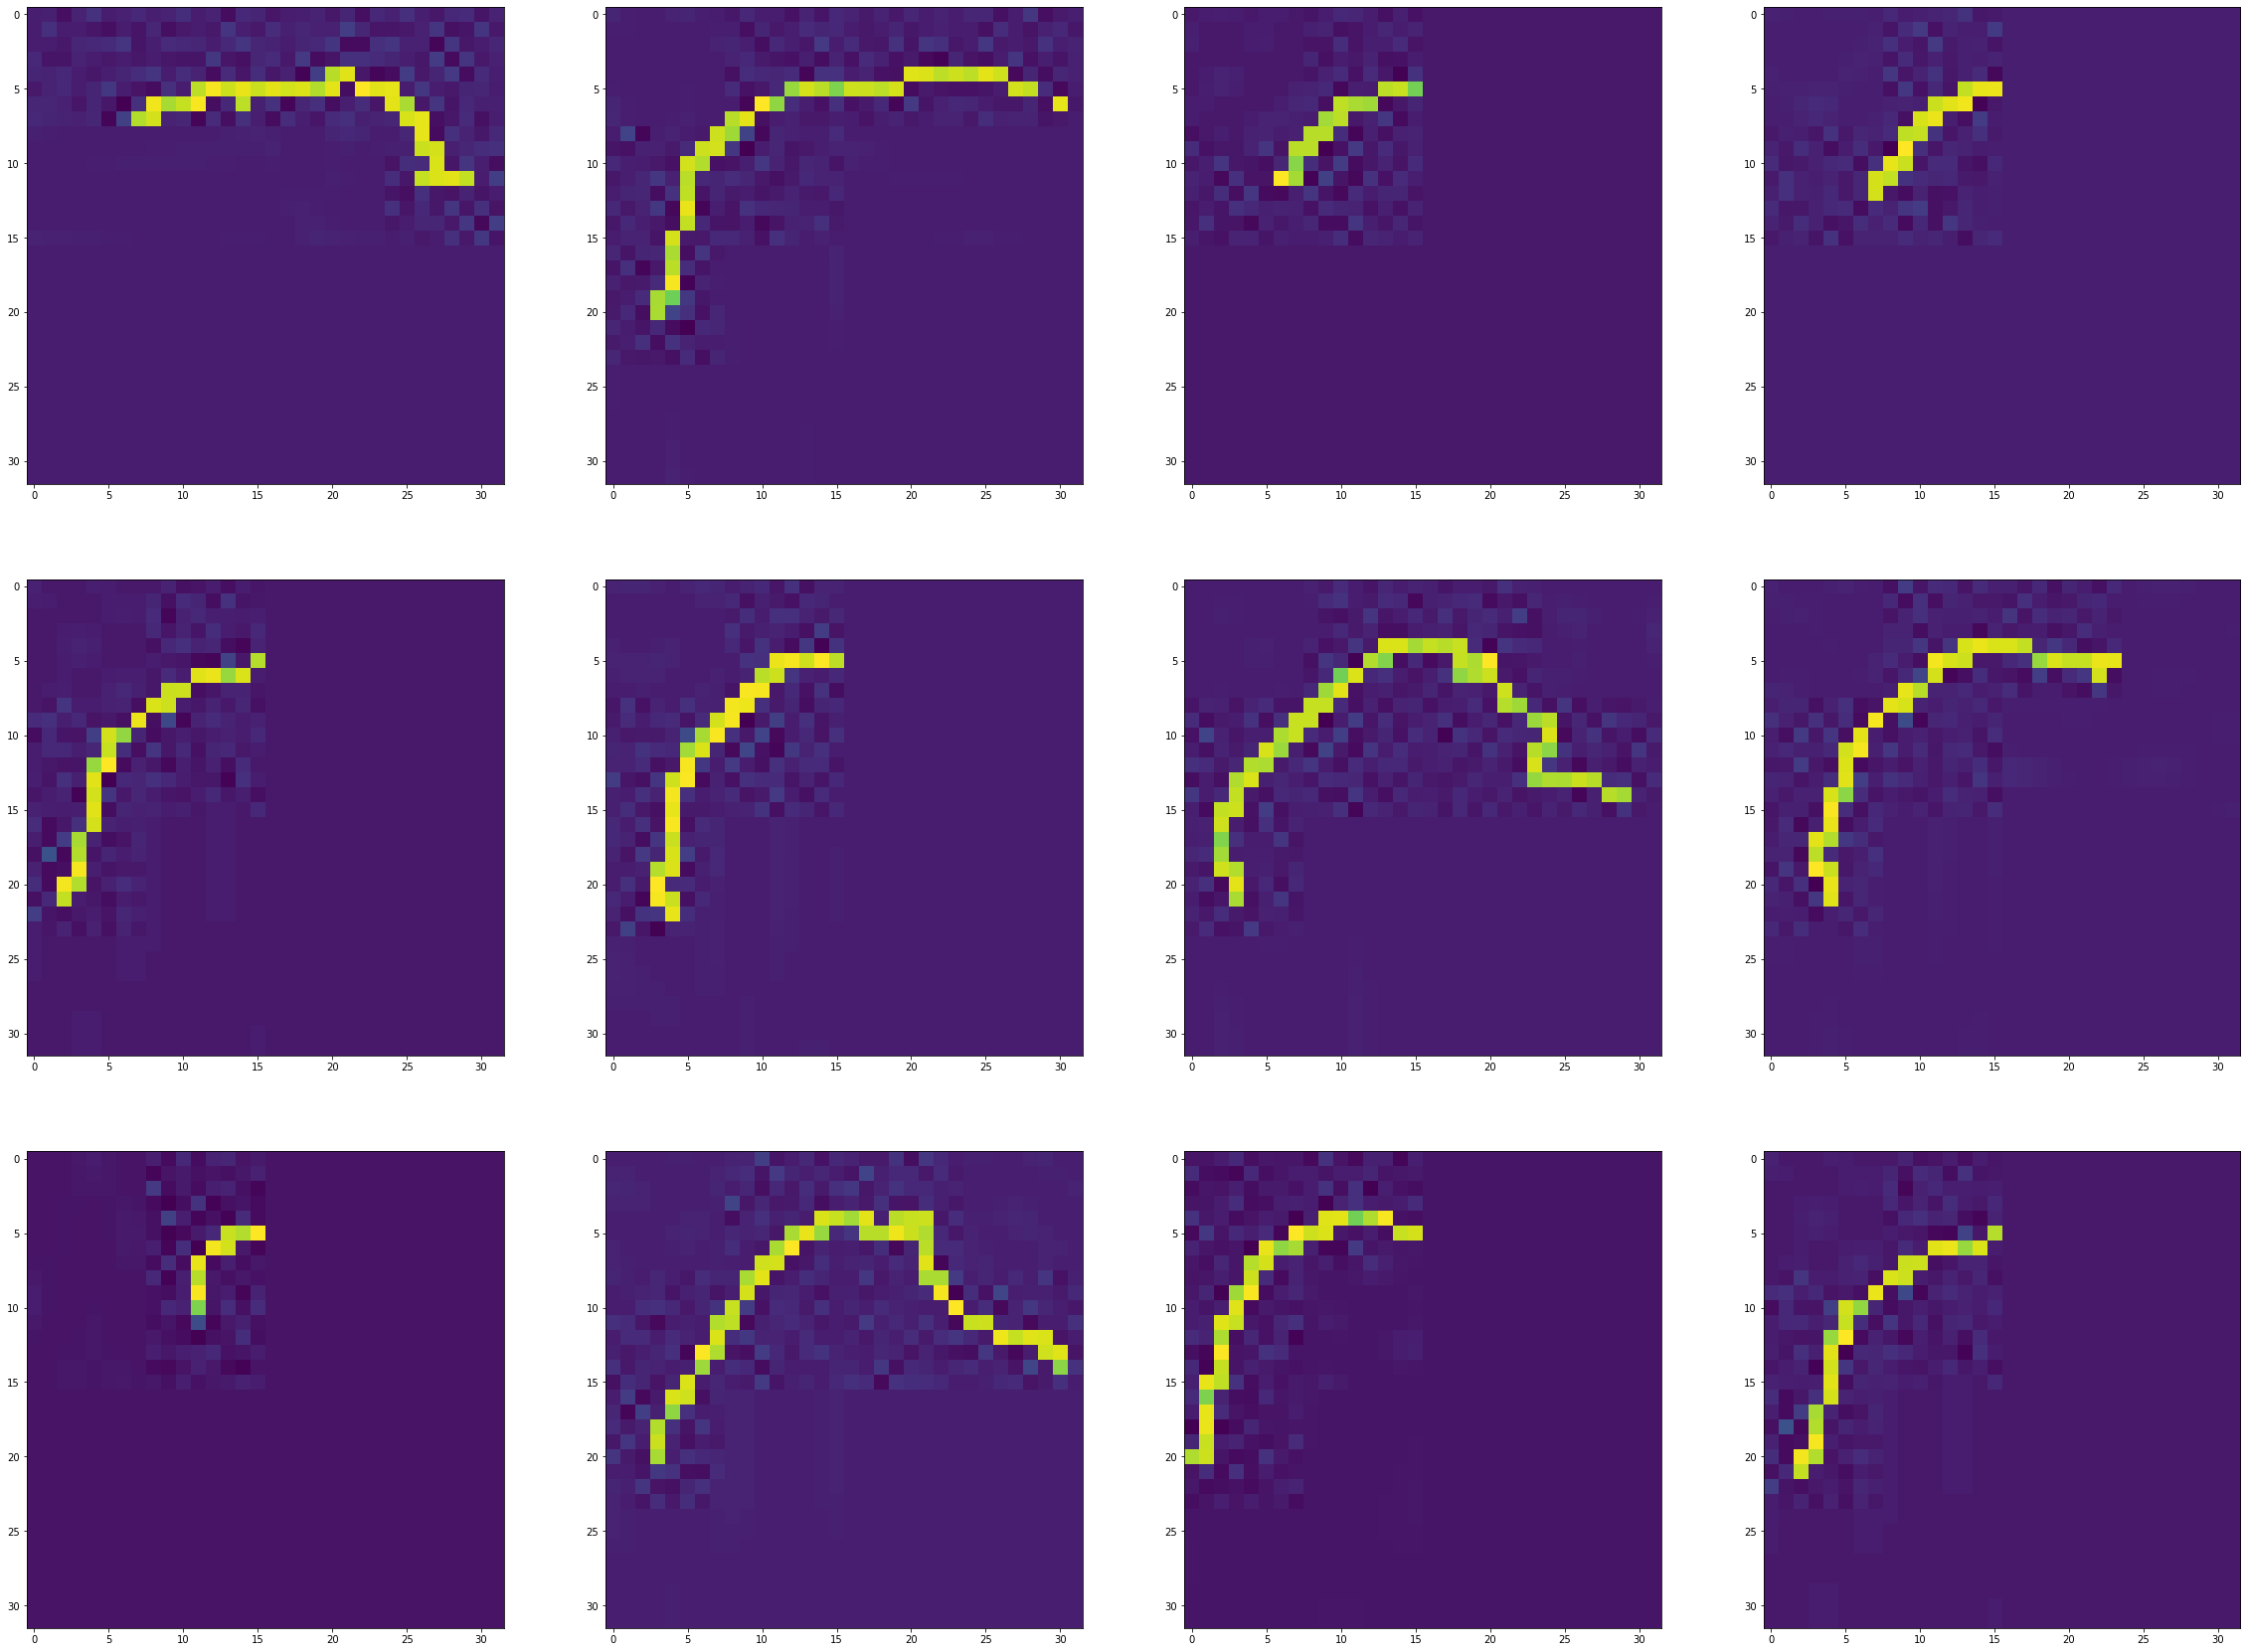

In [7]:
dataset.show()

In [9]:
# model = Unet(
#     dim = 64,
#     dim_mults = (1, 2, 4, 8)
# )

# dataloader = data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)
# batch = next(iter(dataloader))
# print('batch.shape: {}'.format(batch.shape))

# diffusion = GaussianDiffusion(
#     model,
#     image_size = 128,
#     channels= 1,
#     timesteps = 1000,   # number of steps
#     loss_type = 'l1'    # L1 or L2
# )

# # training_images = torch.randn(8, 3, 128, 128) # images are normalized from 0 to 1
# loss = diffusion(batch)
# loss.backward()
# # after a lot of training

# sampled_images = diffusion.sample(batch_size = 4)
# sampled_images.shape # (4, 3, 128, 128)

In [8]:
class DenoiseDiffusion:
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model = eps_model
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps
        self.sigma2 = self.beta

    def q_xt_x0(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean = gather(self.alpha_bar, t) ** 0.5 * x0
        var = 1 - gather(self.alpha_bar, t)
        return mean, var

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):
        if eps is None:
            eps = torch.randn_like(x0)
        mean, var = self.q_xt_x0(x0, t)
        return mean + (var ** 0.5) * eps

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor):
        eps_theta = self.eps_model(xt, t)
        print(f'in p_sample -- xt.shape: {xt.shape}, t.shape: {t.shape}, eps_theta.shape: {eps_theta.shape}')
        alpha_bar = gather(self.alpha_bar, t)
        alpha = gather(self.alpha, t)
        eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        var = gather(self.sigma2, t)

        eps = torch.randn(xt.shape, device=xt.device)
        return mean + (var ** .5) * eps

    def loss(self, x0: torch.Tensor, noise: Optional[torch.Tensor] = None):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)

        if noise is None:
            noise = torch.randn_like(x0)

        xt = self.q_sample(x0, t, eps=noise)
        eps_theta = self.eps_model(xt, t)

        return F.mse_loss(noise, eps_theta)

In [9]:
class Configs(BaseConfigs):
    """
    ## Configurations
    """
    # Device to train the model on.
    # [`DeviceConfigs`](https://docs.labml.ai/api/helpers.html#labml_helpers.device.DeviceConfigs)
    #  picks up an available CUDA device or defaults to CPU.
    device: torch.device = DeviceConfigs()
    # print('device: {}'.format(device))

    # U-Net model for $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$
    eps_model: UNet
    # [DDPM algorithm](index.html)
    diffusion: DenoiseDiffusion

    # Number of channels in the image. $3$ for RGB.
    image_channels: int = 3
    # Image size
    image_size: int = 32
    # Number of channels in the initial feature map
    n_channels: int = 64
    # The list of channel numbers at each resolution.
    # The number of channels is `channel_multipliers[i] * n_channels`
    channel_multipliers: List[int] = [1, 2, 2, 4]
    # The list of booleans that indicate whether to use attention at each resolution
    is_attention: List[int] = [False, False, False, True]

    # Number of time steps $T$
    n_steps: int = 1_000
    # Batch size
    batch_size: int = 64
    # Number of samples to generate
    n_samples: int = 16
    # Learning rate
    learning_rate: float = 2e-5

    data_root: '/home/irmak/Workspace/DAWGE/contrastive_learning/notebooks/diffusion_dset'

    # Number of training epochs
    epochs: int = 1_000

    # Dataset
    dataset: torch.utils.data.Dataset
    # Dataloader
    data_loader: torch.utils.data.DataLoader

    # Adam optimizer
    optimizer: torch.optim.Adam

    def init(self):
        # Create $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$ model
        self.eps_model = UNet(
            image_channels=self.image_channels,
            n_channels=self.n_channels,
            ch_mults=self.channel_multipliers,
            is_attn=self.is_attention,
        ).to(self.device)

        print('self.eps_model: {}'.format(self.eps_model))

        # Create [DDPM class](index.html)
        self.diffusion = DenoiseDiffusion(
            eps_model=self.eps_model,
            n_steps=self.n_steps,
            device=self.device,
        )

        # Create dataloader
        self.data_loader = torch.utils.data.DataLoader(self.dataset, self.batch_size, shuffle=True, pin_memory=True)
        # Create optimizer
        self.optimizer = torch.optim.Adam(self.eps_model.parameters(), lr=self.learning_rate)

        # Image logging
        tracker.set_image("sample", True)

    def sample(self):
        """
        ### Sample images
        """
        with torch.no_grad():
            # $x_T \sim p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$
            x = torch.randn([self.n_samples, self.image_channels, self.image_size, self.image_size],
                            device=self.device)

            # Remove noise for $T$ steps
            for t_ in monit.iterate('Sample', self.n_steps):
                # $t$
                t = self.n_steps - t_ - 1
                # Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$
                x = self.diffusion.p_sample(x, x.new_full((self.n_samples,), t, dtype=torch.long))

            # Log samples
            tracker.save('sample', x)

    def train(self):
        """
        ### Train
        """

        # Iterate through the dataset
        for data in monit.iterate('Train', self.data_loader):
            # Increment global step
            tracker.add_global_step()
            # Move data to device
            data = data.to(self.device)

            # Make the gradients zero
            self.optimizer.zero_grad()
            # Calculate loss
            loss = self.diffusion.loss(data)
            # Compute gradients
            loss.backward()
            # Take an optimization step
            self.optimizer.step()
            # Track the loss
            tracker.save('loss', loss)

    def run(self):
        """
        ### Training loop
        """
        pbar = tqdm(total=self.epochs)
        for _ in monit.loop(self.epochs):
            # Train the model
            self.train()
            # Sample some images
            self.sample()
            # New line in the console
            tracker.new_line()
            # Save the model
            experiment.save_checkpoint()
            pbar.update(1)


In [10]:
class MNISTDataset(torchvision.datasets.MNIST):
    """
    ### MNIST dataset
    """

    def __init__(self, image_size):
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(image_size),
            torchvision.transforms.ToTensor(),
        ])

        super().__init__(str(lab.get_data_path()), train=True, download=True, transform=transform)

    def __getitem__(self, item):
        return super().__getitem__(item)[0]


@option(Configs.dataset, 'MNIST')
def mnist_dataset(c: Configs):
    """
    Create MNIST dataset
    """
    return MNISTDataset(c.image_size)

In [11]:
@option(Configs.dataset, 'RandTraj')
def randtraj_dataset(c: Configs):
    """
    Return the random trajectory dataset
    """

    return RandTrajDataset(c.image_size, c.data_root) # MNIST has 60k images

In [12]:

def main():
    # Create experiment
    experiment.create(name='diffuse', writers={'screen'})

    # Create configurations
    configs = Configs()

    # Set configurations. You can override the defaults by passing the values in the dictionary.
    experiment.configs(configs, {
        'dataset': 'RandTraj',  # 'MNIST'
        'image_channels': 1,  # 1,
        'image_size': IMAGE_SIZE,
        'epochs': 100,  # 5,
        'device': torch.device('cuda:0'),
        'data_root': '/home/irmak/Workspace/DAWGE/contrastive_learning/notebooks/diffusion_mock_dset'
    })

    # Initialize
    configs.init()

    # Set models for saving and loading
    experiment.add_pytorch_models({'eps_model': configs.eps_model})

    # Start and run the training loop
    with experiment.start():
        configs.run()


main()

self.eps_model: UNet(
  (image_proj): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_emb): TimeEmbedding(
    (lin1): Linear(in_features=64, out_features=256, bias=True)
    (act): Swish()
    (lin2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down): ModuleList(
    (0): DownBlock(
      (res): ResidualBlock(
        (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (act1): Swish()
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
        (act2): Swish()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shortcut): Identity()
        (time_emb): Linear(in_features=256, out_features=64, bias=True)
      )
      (attn): Identity()
    )
    (1): DownBlock(
      (res): ResidualBlock(
        (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (act1): Swish()
        (conv1): Conv2d(64, 64, kernel_si

  0%|          | 0/100 [00:00<?, ?it/s]

in p_sample -- xt.shape: torch.Size([16, 1, 32, 32]), t.shape: torch.Size([16]), eps_theta.shape: torch.Size([16, 1, 32, 32])
in p_sample -- xt.shape: torch.Size([16, 1, 32, 32]), t.shape: torch.Size([16]), eps_theta.shape: torch.Size([16, 1, 32, 32])
in p_sample -- xt.shape: torch.Size([16, 1, 32, 32]), t.shape: torch.Size([16]), eps_theta.shape: torch.Size([16, 1, 32, 32])
in p_sample -- xt.shape: torch.Size([16, 1, 32, 32]), t.shape: torch.Size([16]), eps_theta.shape: torch.Size([16, 1, 32, 32])
in p_sample -- xt.shape: torch.Size([16, 1, 32, 32]), t.shape: torch.Size([16]), eps_theta.shape: torch.Size([16, 1, 32, 32])
in p_sample -- xt.shape: torch.Size([16, 1, 32, 32]), t.shape: torch.Size([16]), eps_theta.shape: torch.Size([16, 1, 32, 32])
in p_sample -- xt.shape: torch.Size([16, 1, 32, 32]), t.shape: torch.Size([16]), eps_theta.shape: torch.Size([16, 1, 32, 32])
in p_sample -- xt.shape: torch.Size([16, 1, 32, 32]), t.shape: torch.Size([16]), eps_theta.shape: torch.Size([16, 1, 3

KeyboardInterrupt: 

### Create the same trajectory class for trajectories in the data
1. Traverse through the pos_corners.pickle files 
2. Add the means of the boxes as to the trajectory 
3. Dump the trajectories as images

In [36]:
import pickle
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# This method takes one pos_corner.pickle path and dumps the trajectory 
# as an image
def dump_one_traj(pos_corners_path, traj_num, dump_path):
    with open(pos_corners_path, 'rb') as f:
        pos_corners = pickle.load(f)

    # Get the means of each box
    half_idx = int(pos_corners[0][0].shape[0]/2)
    box_traj = np.zeros((len(pos_corners),2)) # We will only hold the means
    dog_traj = np.zeros((len(pos_corners),2))
    wanted_shape = (IMAGE_SIZE,IMAGE_SIZE)
    act_shape = (1280,720)
    shape_ratio = [act_shape[i] / wanted_shape[i] for i in range(2)]
    # print('shape_ratio: {}'.format(shape_ratio))
    # box_traj_img = np.zeros((1280, 720)) # We will blur the trajectory afterwards
    # dog_traj_img = np.zeros((1280, 720))
    box_traj_img, dog_traj_img = np.zeros(wanted_shape), np.zeros(wanted_shape)

    for i in range(len(pos_corners)):
        curr_pos, _, _ = pos_corners[i]
        # Get the position and the mean of it
        box_pos, dog_pos = curr_pos[:half_idx,:], curr_pos[half_idx:,:]        
        box_mean, dog_mean = np.mean(box_pos, axis=0), np.mean(dog_pos, axis=0)

        # Insert 1 to the images after dividing means with shape_ratio
        box_traj_img[int(box_mean[0]/shape_ratio[0]), int(box_mean[1]/shape_ratio[1])] = 1
        dog_traj_img[int(dog_mean[0]/shape_ratio[0]), int(dog_mean[1]/shape_ratio[1])] = 1

    nrows = 1
    ncols = 2
    fig, axs = plt.subplots(figsize=(ncols*5,nrows*5), nrows=nrows, ncols=ncols)
    fig.suptitle('{} trajectories'.format(pos_corners_path.split('/')[-2]))

    # Draw the box trajectory
    axs[0].imshow(box_traj_img)
    axs[0].set_title('Box Trajectory')
    plt.imsave(os.path.join(dump_path, 'frame_{:05d}.jpg'.format(traj_num*2)), box_traj_img) # The even frames are the box trajectory
    

    # Draw the dog trajectory
    axs[1].imshow(dog_traj_img)
    axs[1].set_title('Dog Trajectory')
    plt.imsave(os.path.join(dump_path, 'frame_{:05d}.jpg'.format(traj_num*2+1)), dog_traj_img) # The even frames are the box trajectory

# pos_corners_path = '/home/irmak/Workspace/DAWGE/src/dawge_planner/data/box_orientation_1_demos/train_demos/box_marker_1/pos_corners_fi_1.pickle'
# dump_one_traj(pos_corners_path)




/tmp/ipykernel_3228424/2071205550.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize=(ncols*5,nrows*5), nrows=nrows, ncols=ncols)


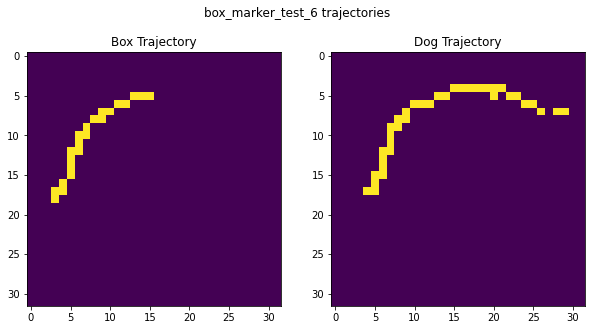

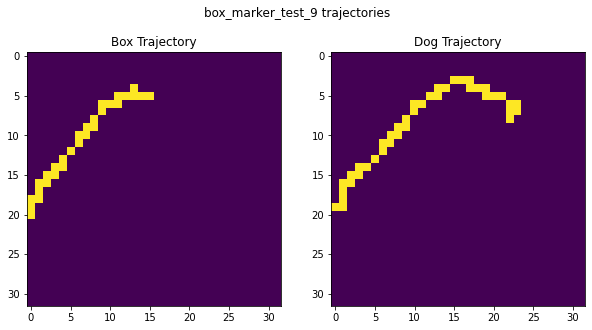

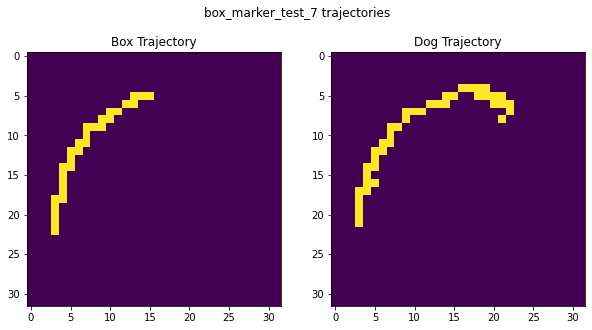

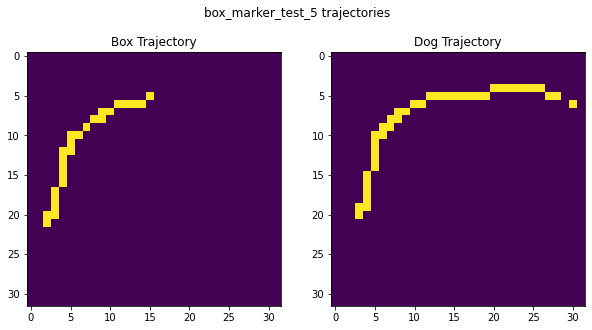

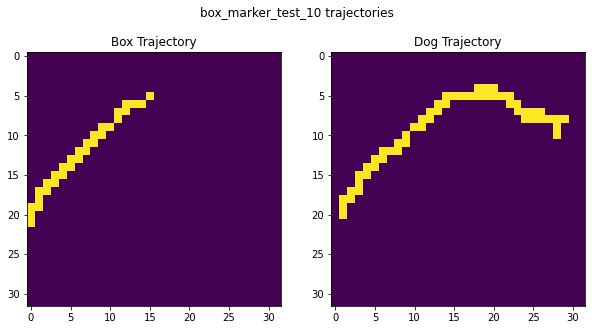

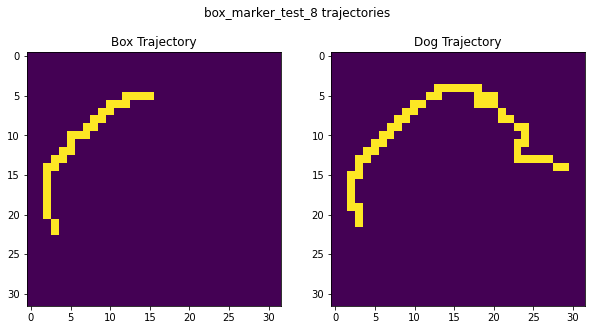

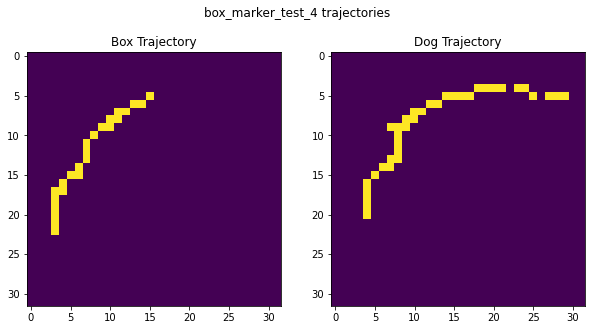

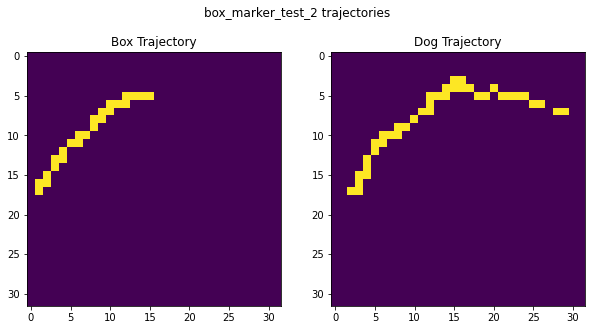

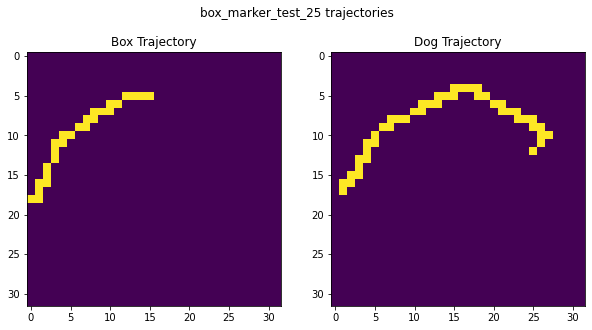

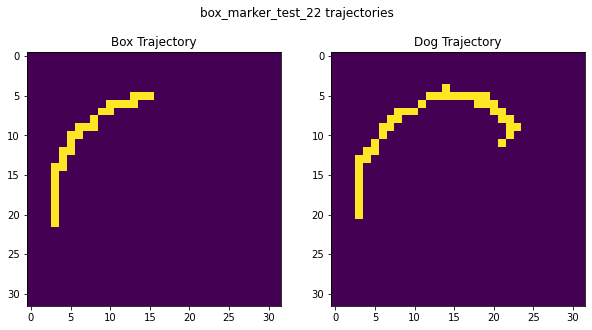

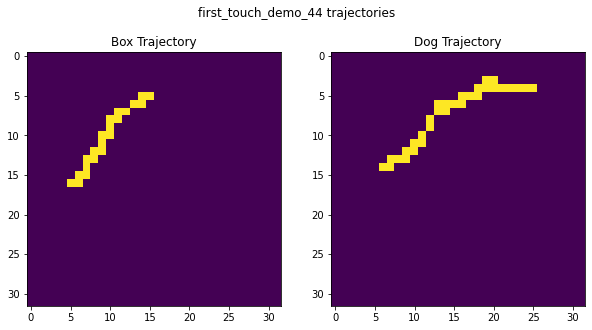

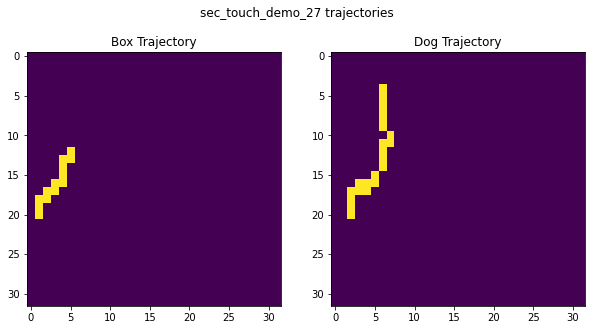

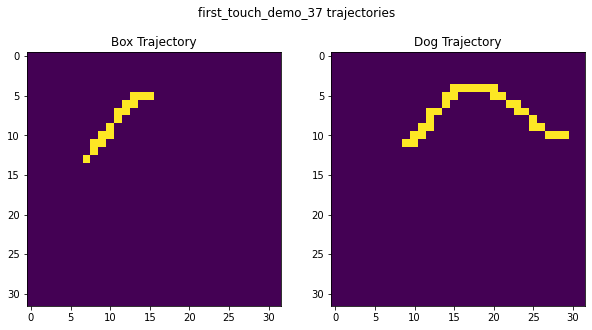

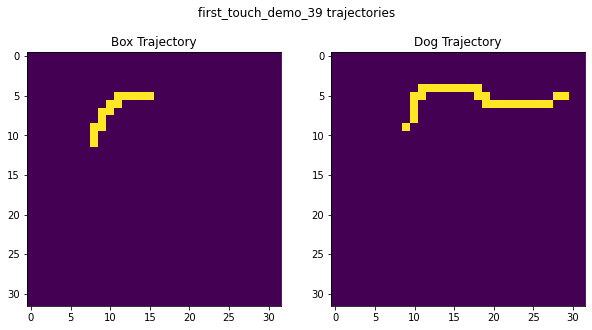

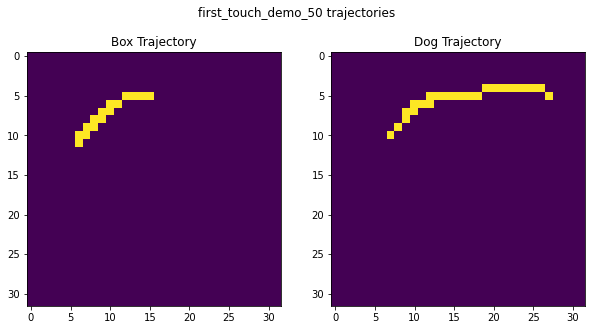

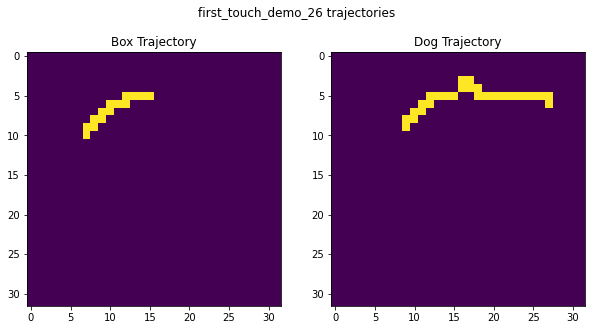

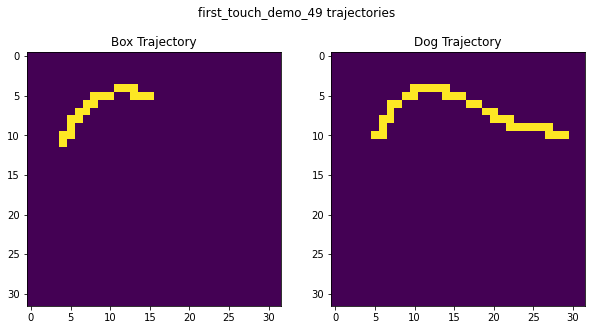

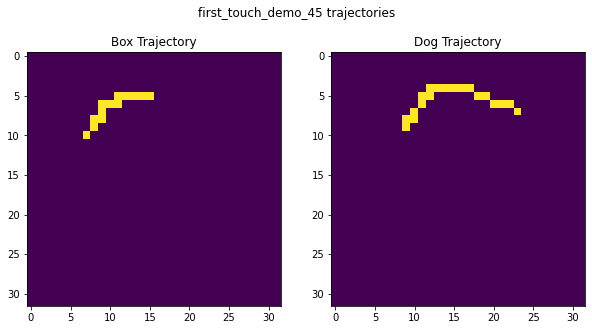

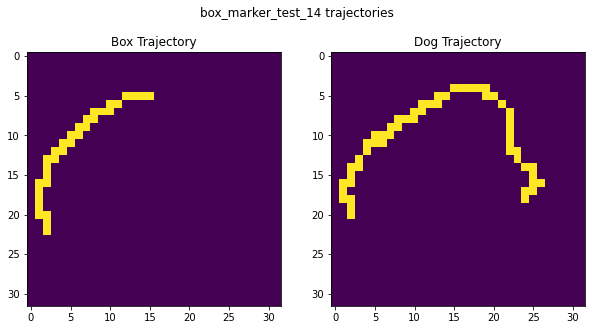

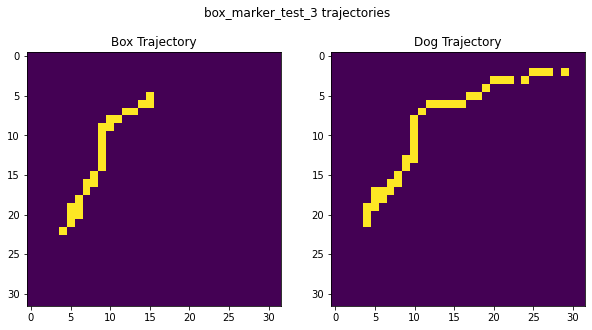

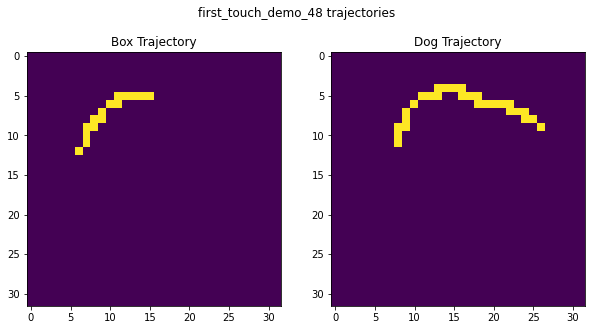

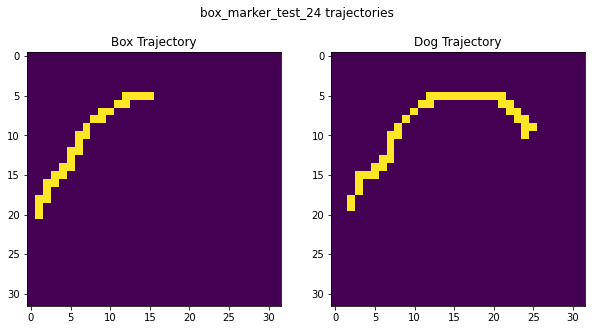

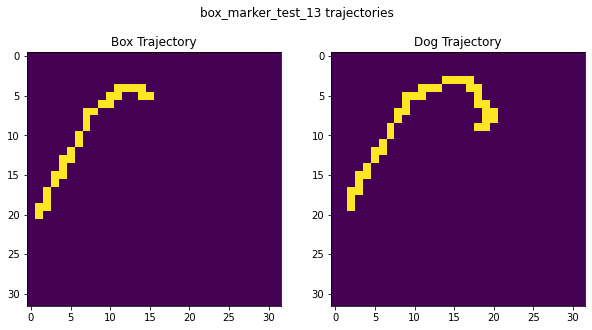

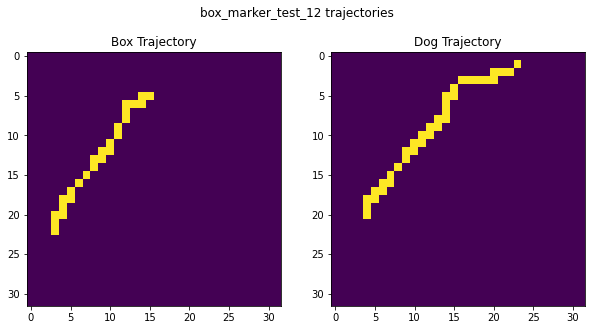

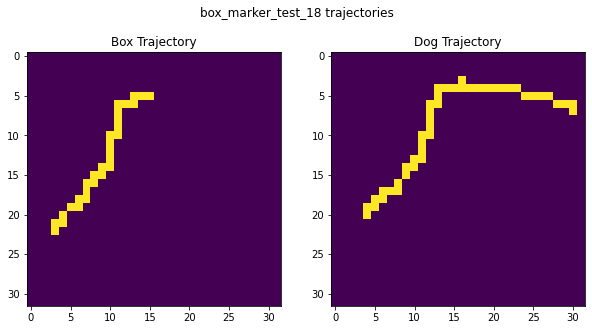

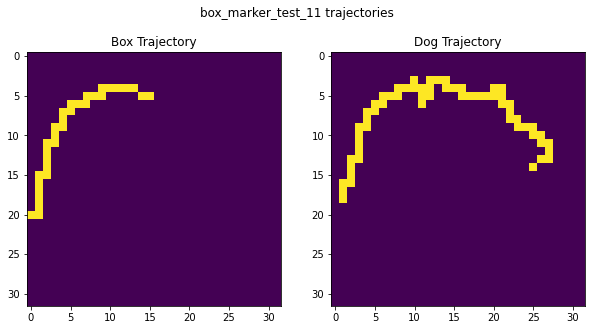

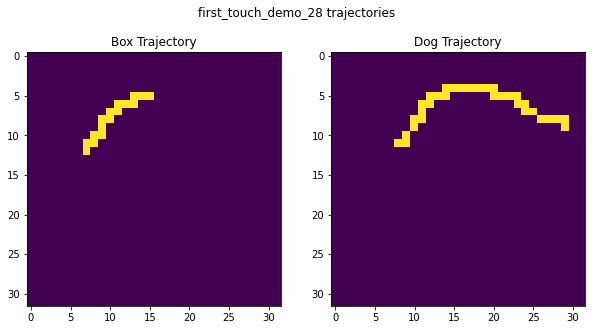

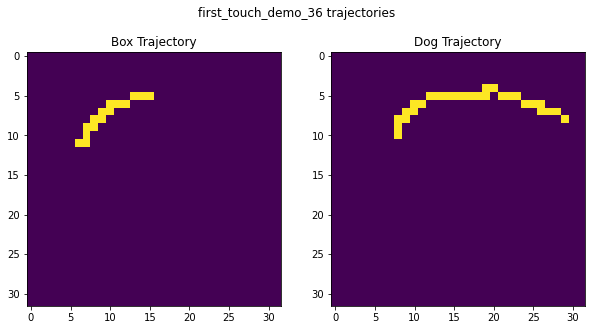

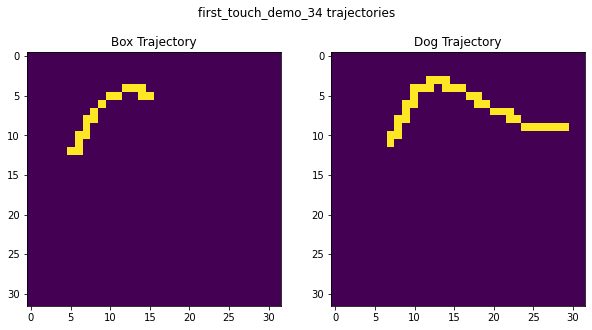

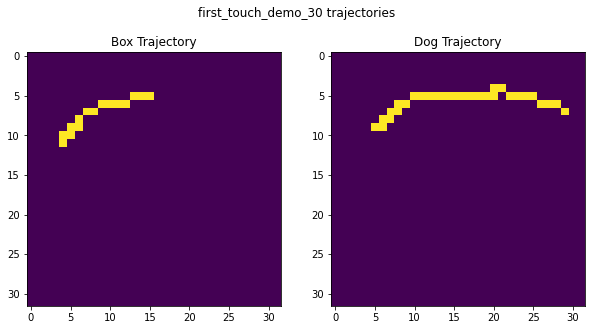

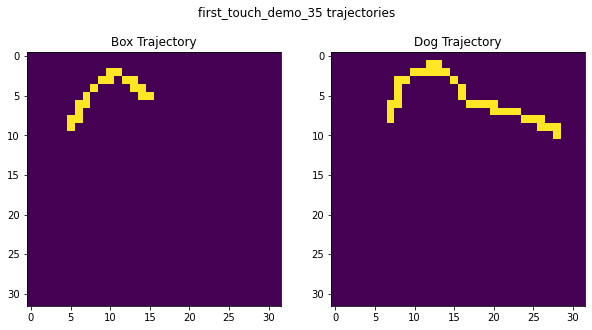

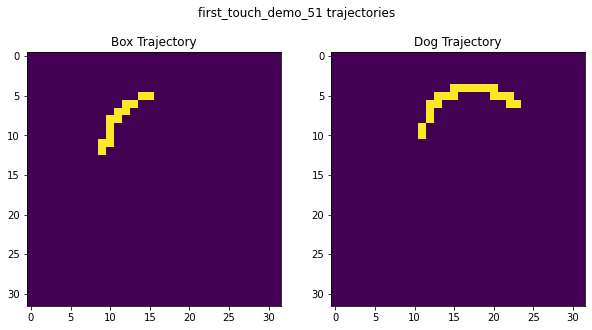

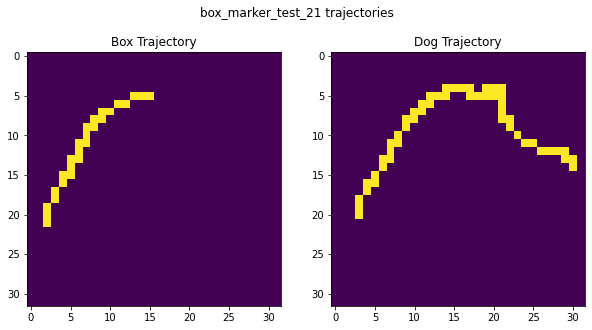

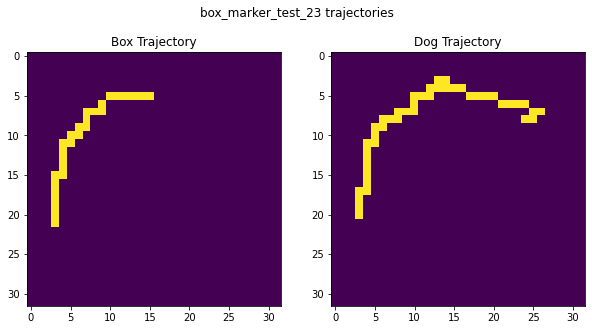

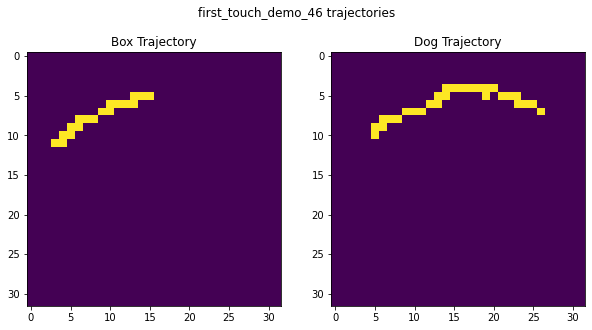

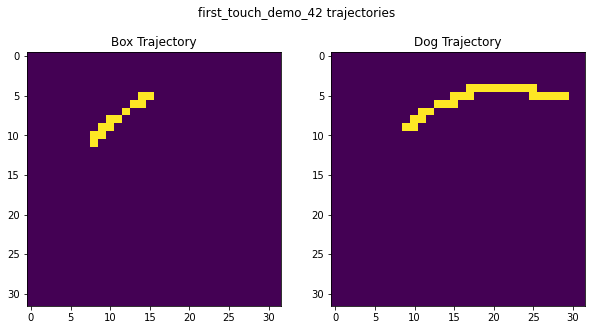

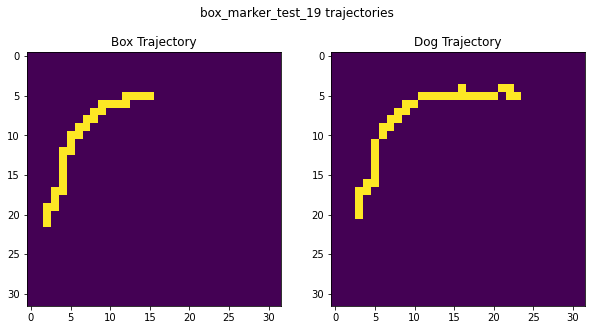

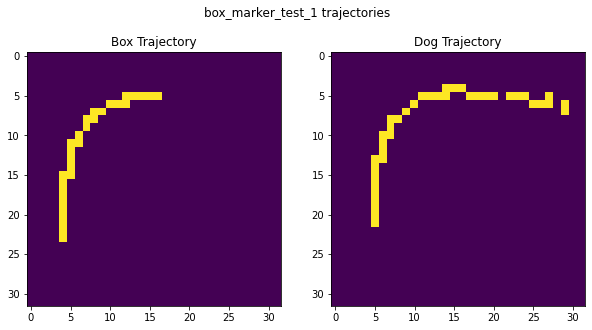

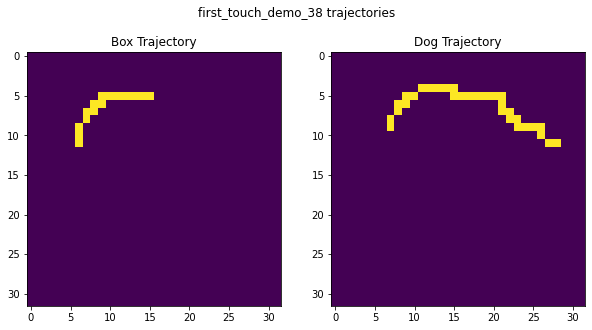

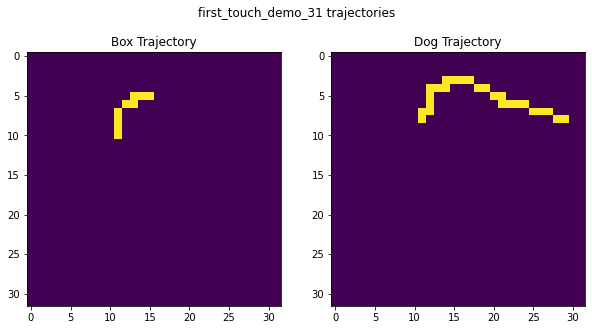

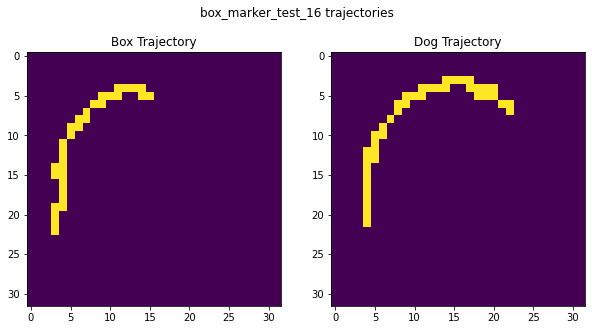

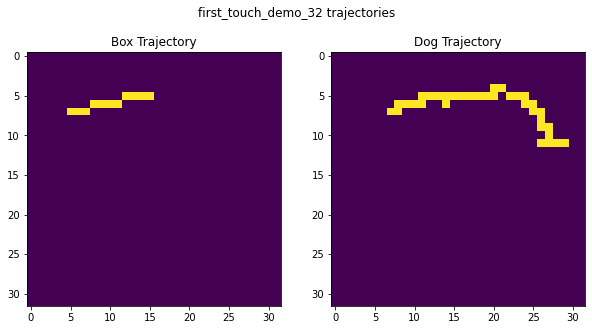

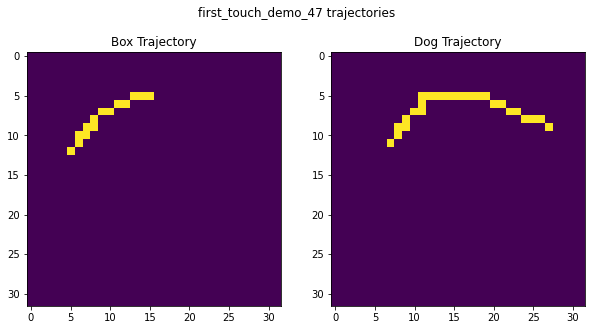

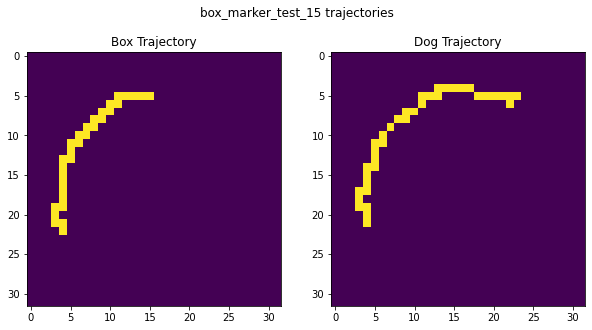

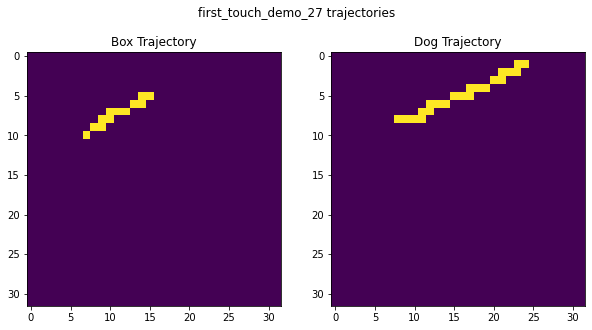

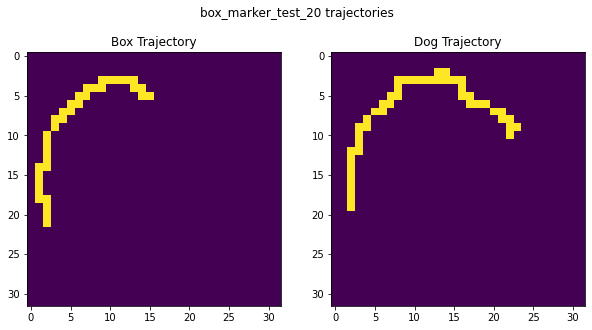

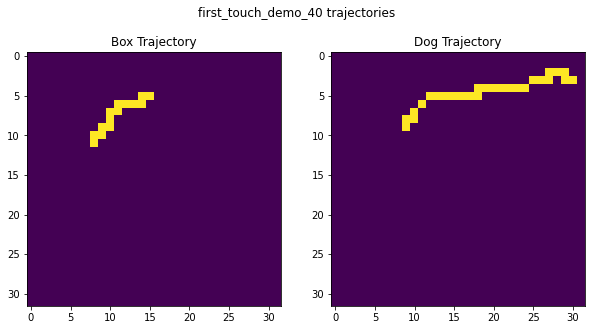

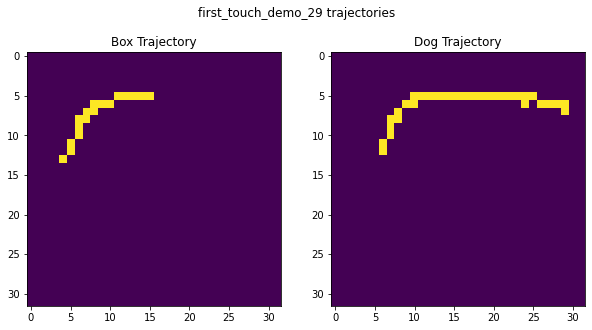

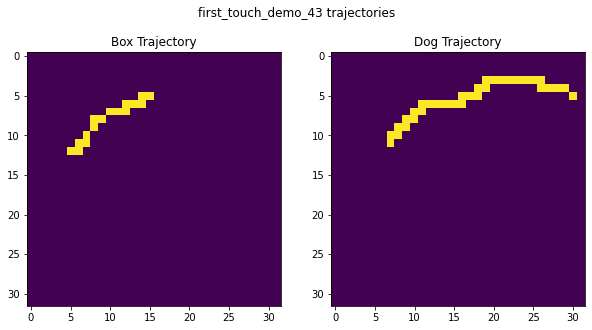

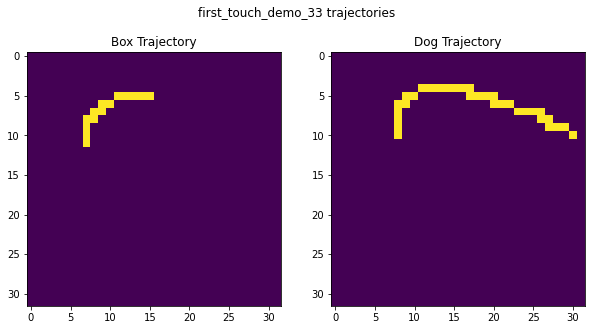

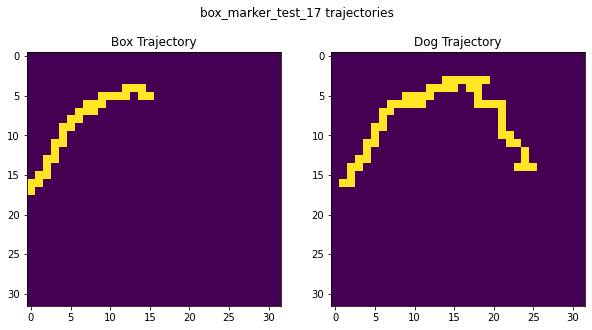

In [39]:
def dump_all_trajectories(roots, dump_path, frame_interval=1): # roots is a list
    pos_corner_paths = []
    for root in roots:
        all_files = glob.glob(f'{root}/*')
        for root in all_files:
            if os.path.isdir(root):
                pos_corner_paths.append(os.path.join(root, 'pos_corners_fi_{}.pickle'.format(frame_interval)))

    # print('pos_corner_paths: {}'.format(pos_corner_paths))
    for i,pos_corner_path in enumerate(pos_corner_paths):
        dump_one_traj(pos_corners_path=pos_corner_path, traj_num=i, dump_path=dump_path)

roots = ['/home/irmak/Workspace/DAWGE/src/dawge_planner/data/box_orientation_2_demos/test_demos',
        #  '/home/irmak/Workspace/DAWGE/src/dawge_planner/data/box_orientation_2_demos/train_demos',
         '/home/irmak/Workspace/DAWGE/src/dawge_planner/data/box_orientation_1_demos/test_demos',
        #  '/home/irmak/Workspace/DAWGE/src/dawge_planner/data/box_orientation_1_demos/train_demos'
        ]
dump_path='/home/irmak/Workspace/DAWGE/contrastive_learning/notebooks/diffusion_dset'
dump_all_trajectories(roots, dump_path)


In [49]:
# Initialize a model to learn the probability distribution for each pixel
# Dataset will go through the imgs pixel by pixel to learn a probability distribution of each pixel
# Input: [x,y] positions of the img + binary flag (dog or box)
# Output: [rt_prob, mt_prob, lt_prob, rm_prob, mm_prob, lm_prob, rb_prob, mb_prob, lb_prob] 9 probabilities for each cell to have the next step (similar to RandTraj class)

def get_prob_dist(is_box: bool):
    # Goes through all the images, calculates the probability distribution for each position in the images
    # return: prob_dist -> numpy array with shape (IMAGE_SIZE,IMAGE_SIZE,9) where each 9 value indicates the probability distribution for each cell
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.CenterCrop((IMAGE_SIZE,IMAGE_SIZE)),
    ])
    
    load_path ='/home/irmak/Workspace/DAWGE/contrastive_learning/notebooks/diffusion_dset'
    all_img_names = glob.glob(f'{load_path}/*')
    num_trajs = int(len(all_img_names) / 2)
    # print(len(all_img_names))
    imgs = np.zeros((num_trajs, IMAGE_SIZE, IMAGE_SIZE))
    for traj_num in range(num_trajs): # They should be able to be divided by two anyways
        if is_box:
            path = os.path.join(load_path, 'frame_{:05d}.jpg'.format(traj_num*2))
        else:
            path = os.path.join(load_path, 'frame_{:05d}.jpg'.format(traj_num*2+1))

        img = np.array(transform(loader(path)))
        imgs[traj_num, img > 100] = 1
    
    imgs_padded = np.pad(imgs, ((0,0),(1,1),(1,1)))

    # Traverse through the imgs and sum the ones and divide them to the number of imgs to get the probability distribution
    img_prob_dist = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 9)) # 9 will be flattened - it starts from left top to right bottom (left to right first, top to bottom second)
    for i in range(1,IMAGE_SIZE+1):
        for j in range(1,IMAGE_SIZE+1):
            all_surr = imgs_padded[:,i-1:i+2,j-1:j+2].reshape(num_trajs,-1) # Ending index should be included as well
            pix_prob_dist = all_surr.mean(axis=0)
            # Multiply everything but 0s to complete them to 1
            pix_sum = pix_prob_dist.sum()
            if pix_sum > 0:
                pix_prob_dist *= 1 / pix_sum

            img_prob_dist[i-1,j-1] = pix_prob_dist

    return img_prob_dist

img_prob_dist = get_prob_dist(True)


imgs.shape before pad: (51, 32, 32)
imgs_padded.shape: (51, 34, 34)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51, 9)
all_surr.shape: (51,

In [52]:
# TODO: Try this out later!! - this could make something nice
rand_traj = RandomTrajectory(IMAGE_SIZE, 1, IMAGE_SIZE*3, use_given_probs=True, given_probs=img_prob_dist)
pbar = tqdm(total=10000)
for _ in range(10000):
    rand_traj.create_traj()
    pbar.update(1)

Shape assertion true!
True


  0%|          | 0/10000 [07:33<?, ?it/s]


ValueError: probabilities do not sum to 1

---------
## Diffusion for next state only
Restart all the imports - this part can be considered as a different notebook

In [2]:

import glob
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import random

from copy import deepcopy
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
from typing import Tuple, Optional, List
from tqdm import tqdm

# Torch imports
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision

from PIL import Image
from torch import nn
from torchvision import transforms
from torchvision.datasets.folder import default_loader as loader 

# # labml imports
# from labml import lab, tracker, experiment, monit
# from labml.configs import BaseConfigs, option
# from labml_helpers.device import DeviceConfigs
# # from labml_nn.diffusion.ddpm.experiment import Configs
# from labml_nn.diffusion.ddpm.utils import gather

### Model Implementations
Implementations for diffusion and linear model to train to get the epsilon_theta in sampling

In [3]:
class PosToThetaLin(nn.Module):
    def __init__(self, input_shape, hidden_shape, output_shape):
        self.model = nn.Sequential(
            nn.Linear(input_shape, hidden_shape), # It will take 2 values and 1 binary flag to indicate if it is box or dog
            nn.ReLU(),
            nn.Linear(hidden_shape, hidden_shape),
            nn.ReLU(),
            nn.Linear(hidden_shape, output_shape) # Output shape will be two values (x and y)
        )

    def forward(self, x):
        return self.model(x)

# Optimizer will be used to train this model

In [4]:
class DenoiseDiffusion:
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model = eps_model
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps # Number of steps to noise and denoise the data
        self.sigma2 = self.beta

    def q_xt_x0(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean = gather(self.alpha_bar, t) ** 0.5 * x0
        var = 1 - gather(self.alpha_bar, t)
        return mean, var

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):
        if eps is None:
            eps = torch.randn_like(x0)
        mean, var = self.q_xt_x0(x0, t)
        return mean + (var ** 0.5) * eps

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor):
        eps_theta = self.eps_model(xt, t)
        # print(f'in p_sample -- xt.shape: {xt.shape}, t.shape: {t.shape}, eps_theta.shape: {eps_theta.shape}')
        alpha_bar = gather(self.alpha_bar, t)
        alpha = gather(self.alpha, t)
        eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        var = gather(self.sigma2, t)

        eps = torch.randn(xt.shape, device=xt.device)
        return mean + (var ** .5) * eps

    def loss(self, x0: torch.Tensor, noise: Optional[torch.Tensor] = None):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)

        if noise is None:
            noise = torch.randn_like(x0)

        xt = self.q_sample(x0, t, eps=noise) # Bu t adim sonra kirlenmis hali olucak
        # xnextt = self.q_sample(xnext0, t, eps=next_noise)



        ''' 
        TODO:
        xnext_t = self.q_sample(x_0, t, eps=noise_next) - BURDA CONDITIONAL BIR SEYE IHTIYACIN OLUCAK
        x_t = self.q_sample(x_0, t, eps=noise_curr)
        eps_theta = self.eps_model(x_t, t) 
        F.mse_loss(noise_next, eps_theta) - x_tyi oyle bi temizlicek ki 
        '''
        eps_theta = self.eps_model(xt, t) # Ikisini de q_sample'a sokucaksin

        return F.mse_loss(noise, eps_theta)

### Training Implementations
Here we will use our regular StateDataset to get the position points
Extract the mean of dog and box separately
Concatenate a flag to indicate if this is a dog or a box
And get the epsilon theta out of there

In [6]:
from omegaconf import OmegaConf
from contrastive_learning.datasets.state_dataset import StateDataset

In [12]:
# Get pixel points using StateDataset
cfg = OmegaConf.create()
cfg.data_dir = '/home/irmak/Workspace/DAWGE/src/dawge_planner/data/box_orientation_1_demos/train_demos'
cfg.pos_ref = 'global' 
cfg.pos_type = 'corners'
cfg.pos_dim = 8
cfg.frame_interval = 1

dataset = StateDataset(cfg)
dataloader = data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)
batch = next(iter(dataloader))
curr_pos, _, _ = [b for b in batch]
# print('batch[0].shape: {}'.format(batch[0].shape))

print('curr_pos[0]: {}'.format(curr_pos[0]))
box_pos = curr_pos[:,:8].reshape(-1,4,2)
dog_pos = curr_pos[:,8:].reshape(-1,4,2)
print('box_pos: {}, dog_pos: {}'.format(box_pos[0], dog_pos[0]))



DATASET POS_REF: global
len(dataset): 6356
self.action_min: [-0.15000001 -0.30000001], self.action_max: [0.15000001 0.30000001]
curr_pos[0]: tensor([0.1622, 0.5259, 0.1598, 0.4825, 0.1979, 0.4685, 0.2019, 0.5105, 0.2303,
        0.7441, 0.2644, 0.6965, 0.2928, 0.7315, 0.2587, 0.7790])
box_pos: tensor([[0.1622, 0.5259],
        [0.1598, 0.4825],
        [0.1979, 0.4685],
        [0.2019, 0.5105]]), dog_pos: tensor([[0.2303, 0.7441],
        [0.2644, 0.6965],
        [0.2928, 0.7315],
        [0.2587, 0.7790]])
